<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture02/notebooks/L02b_softmax_regression_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Runs on CPU or GPU (if available)

# Softmax Regression on MNIST

Implementation of softmax regression (multinomial logistic regression).

## Imports

In [ ]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch

In [ ]:
import matplotlib.pyplot as plt

## Settings and Dataset

In [ ]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.1
num_epochs = 25
batch_size = 256

# Architecture
num_features = 784
num_classes = 10


##########################
### MNIST DATASET
##########################

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # The remaining 20% for validation


train_subset, val_subset = random_split(
    train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)


train_loader = DataLoader(
    dataset=train_subset,
    batch_size=batch_size,
    shuffle=True  # Shuffle the training data
)

val_loader = DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False # No need to shuffle validation data
)


test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())


test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

images, labels = next(iter(train_loader))  # images: [B, 1, 28, 28]


print('Image batch dimensions:', images.shape) #NCHW
print('Image label dimensions:', labels.shape)

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


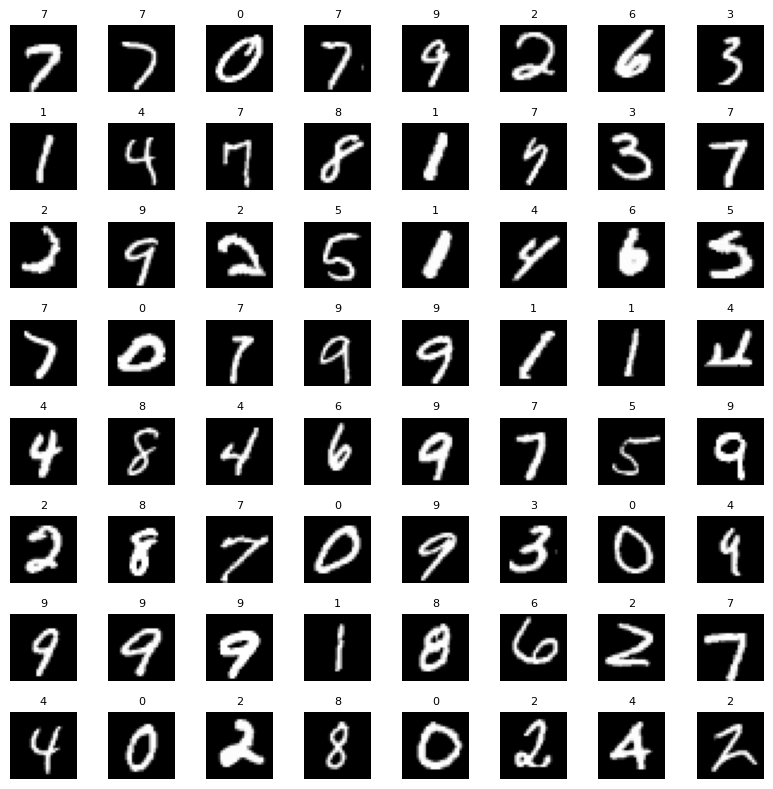

In [ ]:
# Plot first 8x8 = 64 images
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')  # squeeze to [28, 28]
    ax.set_title(str(labels[i].item()), fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
##########################
### MODEL
##########################

class SoftmaxRegression(torch.nn.Module):
    def __init__(self, num_features, num_classes,device):
        super(SoftmaxRegression, self).__init__()

        # 1. Manually define the weight and bias tensors
        self.W = torch.randn(num_features, num_classes) * 0.01
        self.b = torch.zeros(num_classes)

        self.W = self.W.to(device)
        self.b = self.b.to(device)

    def forward_pass(self,X):
        """Manually performs the forward pass: x @ W + b"""
        Z = torch.matmul(X, self.W) + self.b
        Yhat = F.softmax(Z, dim=1)
        return Z,Yhat

    def backward_pass(self,X, Y, Yhat):
        """Manually computes gradients for W and b."""
        num_classes = Yhat.shape[1]
        y_true_one_hot = F.one_hot(Y, num_classes=num_classes)
        grad_logits = Yhat - y_true_one_hot
        grad_W = torch.matmul(X.T, grad_logits)
        grad_b = torch.sum(grad_logits, dim=0)
        return grad_W, grad_b

class CrossEntropyLoss(torch.nn.Module):
    """
    Una implementación desde cero de la pérdida de Entropía Cruzada como una clase.
    """
    def __init__(self, reduction='mean'):
        """
        Args:
            reduction (str): Especifica la reducción a aplicar a la salida:
                             'none' | 'mean' | 'sum'.
        """
        super(CrossEntropyLoss, self).__init__()
        self.reduction = reduction

    def forward(self, Z, Yhat, Y):
        """
        Calcula la pérdida.

        Args:
            logits (torch.Tensor): Las puntuaciones crudas del modelo (batch_size, num_classes).
            targets (torch.Tensor): Las etiquetas verdaderas (batch_size).
        """
        # 2. Obtener el número de clases y codificar las etiquetas en one-hot
        num_classes = Z.shape[1]
        y_true_one_hot = F.one_hot(Y, num_classes=num_classes)

        # 3. Clip para estabilidad numérica, evitando log(0)
        Yhat = torch.clamp(Yhat, 1e-9, 1.0)

        # 4. Calcular la pérdida de log-likelihood para cada elemento del batch
        loss_per_example = -torch.sum(y_true_one_hot * torch.log(Yhat), dim=1)

        # 5. Aplicar la reducción (promedio, suma, o ninguna)
        if self.reduction == 'mean':
            return torch.mean(loss_per_example)
        elif self.reduction == 'sum':
            return torch.sum(loss_per_example)
        else: # 'none'
            return loss_per_example


🚀 Comenzando entrenamiento con guardado de historial...
Época: 01/10 | Train Loss: 0.7661, Train Acc: 83.42% | Val Loss: 0.5079, Val Acc: 87.18%
Época: 02/10 | Train Loss: 0.4504, Train Acc: 88.28% | Val Loss: 0.4304, Val Acc: 88.68%
Época: 03/10 | Train Loss: 0.3983, Train Acc: 89.34% | Val Loss: 0.3985, Val Acc: 89.04%
Época: 04/10 | Train Loss: 0.3722, Train Acc: 89.95% | Val Loss: 0.3788, Val Acc: 89.58%
Época: 05/10 | Train Loss: 0.3556, Train Acc: 90.26% | Val Loss: 0.3671, Val Acc: 89.80%
Época: 06/10 | Train Loss: 0.3438, Train Acc: 90.53% | Val Loss: 0.3569, Val Acc: 90.10%
Época: 07/10 | Train Loss: 0.3348, Train Acc: 90.74% | Val Loss: 0.3506, Val Acc: 90.18%
Época: 08/10 | Train Loss: 0.3275, Train Acc: 90.94% | Val Loss: 0.3452, Val Acc: 90.27%
Época: 09/10 | Train Loss: 0.3216, Train Acc: 91.08% | Val Loss: 0.3404, Val Acc: 90.36%
Época: 10/10 | Train Loss: 0.3166, Train Acc: 91.23% | Val Loss: 0.3366, Val Acc: 90.49%

✅ ¡Entrenamiento completado!


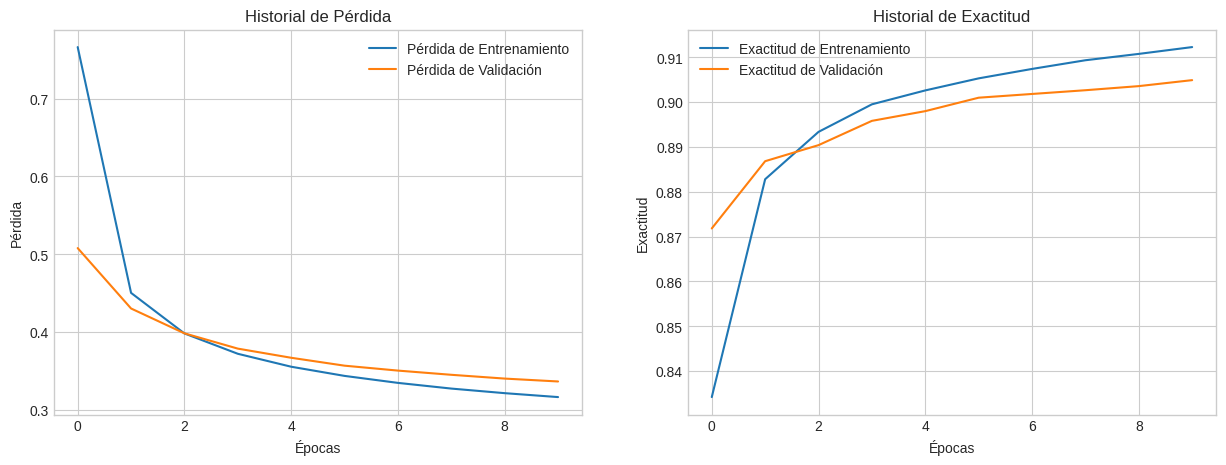

In [ ]:
# ===================================================================
# BUCLE PRINCIPAL DE ENTRENAMIENTO
# ===================================================================

# Instanciar el modelo y la función de pérdida
model = SoftmaxRegression(num_features, num_classes,device)
loss_fn = CrossEntropyLoss().to(device)
epochs = 10


# --- 1. INICIALIZAR EL HISTORIAL ---
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("🚀 Comenzando entrenamiento con guardado de historial...")

for epoch in range(epochs):
    # --- BUCLE DE ENTRENAMIENTO ---
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_samples = 0

    for batch_idx, (features, targets) in enumerate(train_loader):
        X = features.view(-1, 28*28).to(device)
        Y = targets.to(device)

        # Forward, Loss, Backward, Update...
        Z,Yhat = model.forward_pass(X)
        loss = loss_fn(Z, Yhat, Y)
        grad_W, grad_b = model.backward_pass(X, Y, Yhat)

        with torch.no_grad():
            model.W -= learning_rate * (grad_W / batch_size)
            model.b -= learning_rate * (grad_b / batch_size)

        # Acumular métricas de entrenamiento
        running_train_loss += loss.item() * X.size(0)
        train_preds = torch.argmax(Z, dim=1)
        correct_train_preds += (train_preds == Y).sum().item()
        total_train_samples += Y.size(0)

    # --- BUCLE DE VALIDACIÓN ---
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_samples = 0
    with torch.no_grad():
        for features, targets in val_loader:
            X_val = features.view(-1, 28*28).to(device)
            Y_val = targets.to(device)

            Z_val, Yhat_val = model.forward_pass(X_val)
            val_loss = loss_fn(Z_val, Yhat_val, Y_val)

            # Acumular métricas de validación
            running_val_loss += val_loss.item() * X_val.size(0)
            val_preds = torch.argmax(Z_val, dim=1)
            correct_val_preds += (val_preds == Y_val).sum().item()
            total_val_samples += Y_val.size(0)

    # --- 2. CALCULAR Y GUARDAR MÉTRICAS DE LA ÉPOCA ---
    epoch_train_loss = running_train_loss / total_train_samples
    epoch_train_acc = correct_train_preds / total_train_samples

    epoch_val_loss = running_val_loss / total_val_samples
    epoch_val_acc = correct_val_preds / total_val_samples

    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Época: {epoch+1:02d}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc*100:.2f}%")

print("\n✅ ¡Entrenamiento completado!")

# ===================================================================
# 3. CÓDIGO PARA GRAFICAR LOS RESULTADOS
# ===================================================================
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica de Pérdida (Loss)
ax1.plot(history['train_loss'], label='Pérdida de Entrenamiento')
ax1.plot(history['val_loss'], label='Pérdida de Validación')
ax1.set_title('Historial de Pérdida')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.legend()

# Gráfica de Exactitud (Accuracy)
ax2.plot(history['train_acc'], label='Exactitud de Entrenamiento')
ax2.plot(history['val_acc'], label='Exactitud de Validación')
ax2.set_title('Historial de Exactitud')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Exactitud')
ax2.legend()

plt.show()

In [ ]:
correct_test_preds = 0
total_test_samples = 0


for features, targets in test_loader:
    X_test = features.view(-1, 28*28).to(device)
    Y_test = targets.to(device)

    # Obtener las predicciones del modelo
    Z_test, Yhat_test = model.forward_pass(X_test)
    predicted_labels = torch.argmax(Z_test, dim=1)

    # Acumular el número de predicciones correctas
    correct_test_preds += (predicted_labels == Y_test).sum().item()
    total_test_samples += Y_test.size(0)

# Calcular la exactitud final
final_test_accuracy = (correct_test_preds / total_test_samples) * 100

print(f"\nExactitud Final en el Conjunto de Prueba: {final_test_accuracy:.2f}%")


Exactitud Final en el Conjunto de Prueba: 91.50%


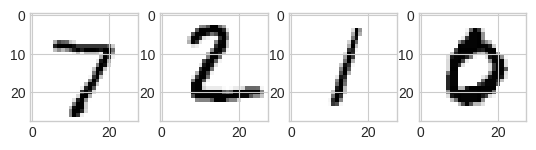

In [ ]:
import matplotlib
for features, targets in test_loader:
    break

fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
_, predictions = model.forward_pass(features[:4].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([7, 2, 1, 0], device='cuda:0')
